#### Outline

1. [Import data, create phyloseq object, subset data](#section1)
2. [Relative abundance of taxa](#section2)
3. [Bray curtis comparison with wilcoxon rank sum test](#section3) 
4. [PERMANOVA](#section4) 
5. [Bray curtis comparison with wilcoxon rank sum test-remove NTC contam](#section5) 


<a id='section1'></a>

# 1. Import data, create phyloseq object, subset data

In [1]:
setwd("~/Box/Pickering_projects/Pickering_16s_bd")
library(phyloseq)
library(ggplot2)
library(tidyr)
suppressMessages(library(dplyr))
suppressMessages(library(vegan))
library(scales)
library(forcats)

In [2]:
#create object from dada2 
taxa <- readRDS("taxa_species_2.rds")
seqtab.nochim <- readRDS("seqtab_2.rds")

metadata<-read.table("metadata.tsv", sep='\t', header=T, row.names=1, comment="")

# Construct phyloseq object from dada2 outputs and metadata table
ps<- phyloseq(otu_table(seqtab.nochim, taxa_are_rows=FALSE), 
               sample_data(metadata), 
               tax_table(taxa))
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5791 taxa and 96 samples ]
sample_data() Sample Data:       [ 96 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 5791 taxa by 7 taxonomic ranks ]

In [3]:
#subset phyloseq object to bacteria
ps_bacteria <- subset_taxa(ps, Kingdom=="Bacteria")
#ps_bacteria

In [4]:
#remove taxa associated with eukaryotes (Mitochondria and Chloroplast) 
ps_bacteria <- subset_taxa(ps_bacteria, Family !="Mitochondria")
ps_bacteria <- subset_taxa(ps_bacteria, Order !="Chloroplast")

In [5]:
#remove human rural 5 and 6 because they are individual samples not composites
ps_bacteria <- subset_samples(ps_bacteria, Sample !="RRL_HMN5")
ps_bacteria <- subset_samples(ps_bacteria, Sample !="RRL_HMN6")
#sample_data(ps_bacteria)

In [6]:
#transform ASV counts based on inverse hyperbolic sine transformation-allows for the inclusion of zero values 
ps_samples_norm = transform_sample_counts(ps_bacteria, function(x) asinh(x))
#sample_data(ps_samples_norm)

In [7]:
#merge by sum
sample_data(ps_samples_norm)$Type <- as.factor(sample_data(ps_samples_norm)$Type)
sample_data(ps_samples_norm)$Urban <- as.factor(sample_data(ps_samples_norm)$Urban)
ps_samples_sum = merge_samples(ps_samples_norm, group="Sample", fun= "sum")
ps_samples_sum
#sample_data(ps_samples_sum)

Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”
Warning message in asMethod(object):
“NAs introduced by coercion”


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5057 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 5057 taxa by 7 taxonomic ranks ]

In [8]:
#reassign animal and location 
sample_data(ps_samples_sum)$anm<-ifelse(sample_data(ps_samples_sum)$Type== 6, "chicken", 
                                         ifelse(sample_data(ps_samples_sum)$Type==9, "goat", "human"))
sample_data(ps_samples_sum)$anm<-ifelse(sample_data(ps_samples_sum)$Urban== 1, "Blank", sample_data(ps_samples_sum)$anm)
sample_data(ps_samples_sum)$anm<-ifelse(sample_data(ps_samples_sum)$Urban== 2, "NTC", sample_data(ps_samples_sum)$anm)
sample_data(ps_samples_sum)$anm<-ifelse(sample_data(ps_samples_sum)$Urban== 3, "Pos", sample_data(ps_samples_sum)$anm)

sample_data(ps_samples_sum)$loc<-ifelse(sample_data(ps_samples_sum)$Urban== 15, "urban", "rural")
sample_data(ps_samples_sum)$loc<-ifelse(sample_data(ps_samples_sum)$Urban== 1, "Blank", sample_data(ps_samples_sum)$loc)
sample_data(ps_samples_sum)$loc<-ifelse(sample_data(ps_samples_sum)$Urban== 2, "NTC", sample_data(ps_samples_sum)$loc)
sample_data(ps_samples_sum)$loc<-ifelse(sample_data(ps_samples_sum)$Urban== 3, "Pos", sample_data(ps_samples_sum)$loc)

sample_data(ps_samples_sum)$Type<-ifelse(sample_data(ps_samples_sum)$LinkerPrimerSequence== 1, 1, sample_data(ps_samples_sum)$Type)
#sample_data(ps_samples_sum)


In [9]:
#subset data 
ps_ch <- subset_samples(ps_samples_sum, subset = anm %in% c("chicken"))
ps_g <- subset_samples(ps_samples_sum, subset = anm %in% c("goat"))
ps_h <- subset_samples(ps_samples_sum, subset = anm %in% c("human"))
ps_all<-subset_samples(ps_samples_sum, subset = anm %in% c("chicken", "goat", "human"))

#subset data for pairwise comparisons 
ps_ch_u<- subset_samples(ps_samples_sum, subset = anm %in% c("chicken", "human")& loc %in% c("urban"))
ps_ch_r<- subset_samples(ps_samples_sum, subset = anm %in% c("chicken", "human")& loc %in% c("rural"))
ps_gh_u<- subset_samples(ps_samples_sum, subset = anm %in% c("goat", "human")& loc %in% c("urban"))
ps_gh_r<- subset_samples(ps_samples_sum, subset = anm %in% c("goat", "human")& loc %in% c("rural"))

In [10]:
#transform ASV counts to a percentage for taxonomy graphs 
ps_prop <- transform_sample_counts(ps_samples_sum, function(OTU) 100* OTU/sum(OTU))
#sample_data(ps_prop)
                                   
##subset samples percentages-for taxonomy graphs
ps_ch_prop <- subset_samples(ps_prop, subset = anm %in% c("chicken"))
ps_g_prop <- subset_samples(ps_prop, subset = anm %in% c("goat"))
ps_h_prop <- subset_samples(ps_prop, subset = anm %in% c("human"))
ps_all_prop<-subset_samples(ps_prop, subset = anm %in% c("chicken", "goat", "human"))
ps_control<-subset_samples(ps_prop, subset = anm %in% c("NTC", "Blank", "Pos"))

<a id='section2'></a>

# 2. Taxonomy 

In [11]:
fam <- tax_glom(ps_prop, taxrank = 'Family', NArm=FALSE)
top30 <- names(sort(taxa_sums(fam), decreasing=TRUE))[1:30]
ps.top30 <- prune_taxa(top30, fam)

In [12]:
#melt<-psmelt(ps.top30)
#write.csv(melt, "melt_other.csv")

other_dat<-read.csv("melt_other.csv")
#other_dat

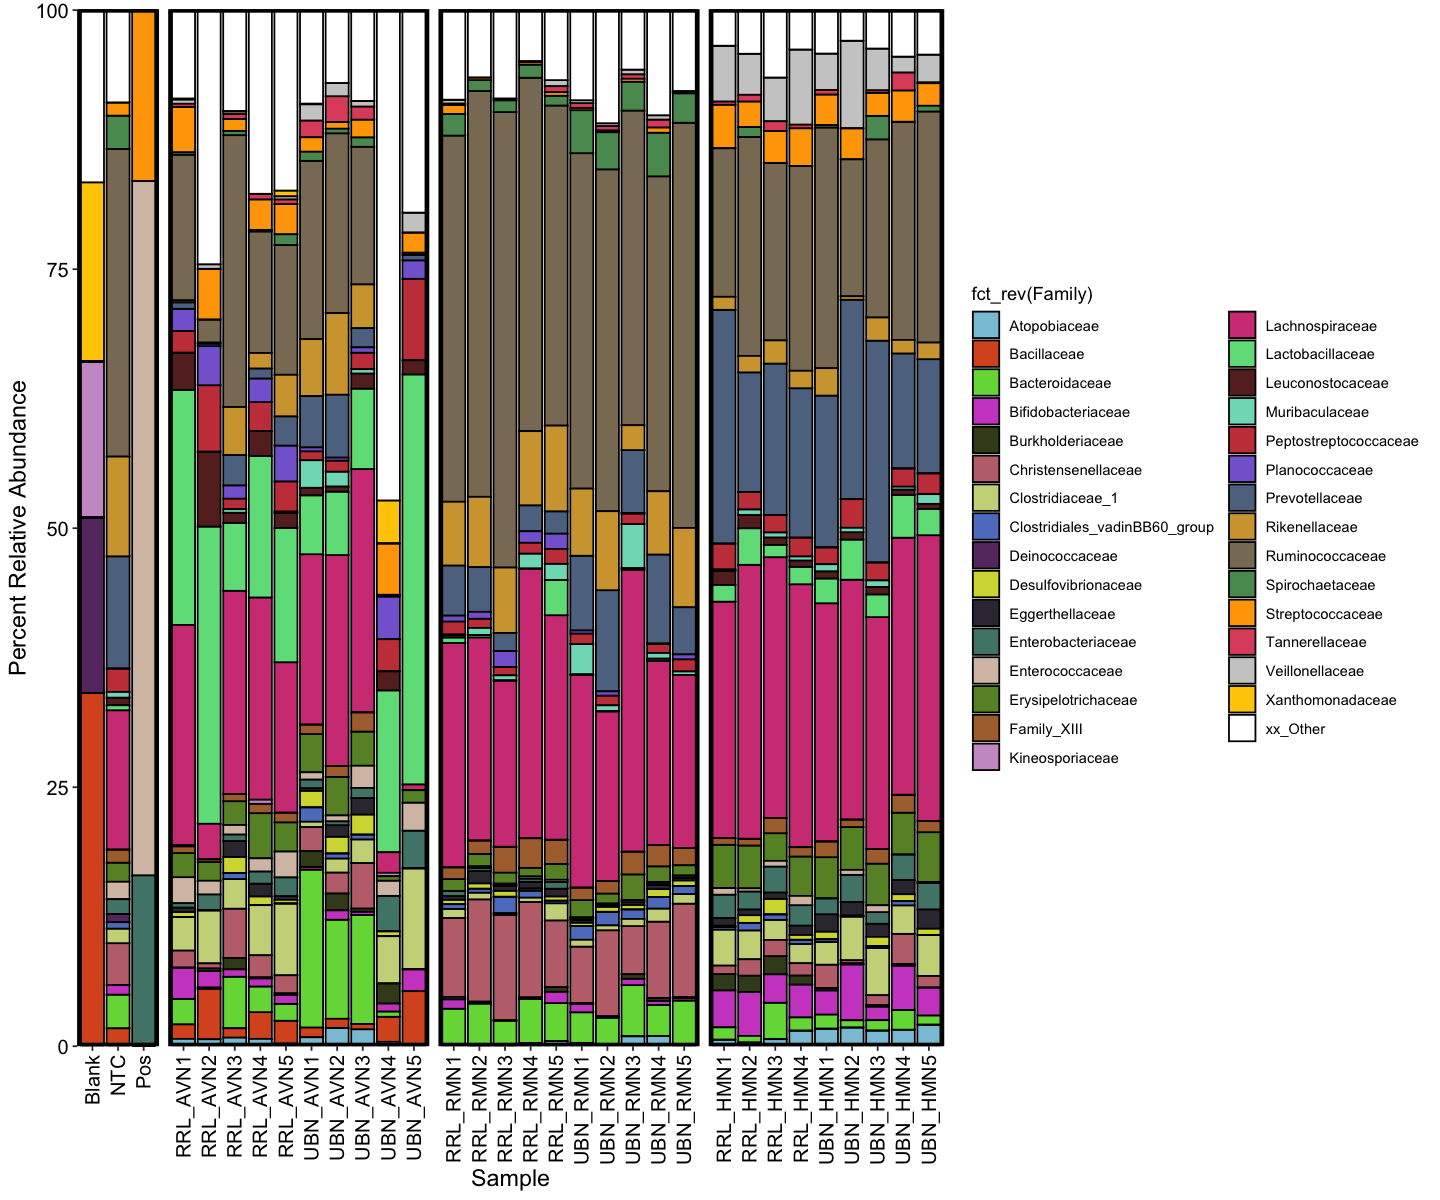

In [13]:
colors <- c("#89C5DA", "#DA5724", "#74D944", "#CE50CA", "#3F4921", "#C0717C", "#CBD588", "#5F7FC7", 
            "#673770", "#D3D93E", "#38333E", "#508578", "#D7C1B1", "#689030", "#AD6F3B", "#CD9BCD", 
            "#D14285", "#6DDE88", "#652926", "#7FDCC0",  "#C84248", "#8569D5", "#5E738F", "#D1A33D", 
            "#8A7C64", "#599861", "orange", "666666", "gray80", "#FFCC00","white" )
colors<-rev(colors)

#plot top 30 families by sample type 
options(repr.plot.width = 12, repr.plot.height = 10)
plot_other<-ggplot(dat=other_dat, aes(x=Sample,y=Abundance, fill=fct_rev(Family))) + 
geom_bar(aes(), stat="identity", position="stack", color="black")+
scale_fill_manual(values = colors) + 
scale_y_continuous(limits = c(0,100.1), expand = c(0, 0))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA, size=2),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5, size=12, color="black"),
        axis.text.y = element_text(size=12, color="black"),strip.background = element_blank(),
       strip.text.x = element_blank(),axis.title.y = element_text(size=14, color="black"),axis.title.x = element_text(size=14, color="black"))+
facet_grid(.~Type, scales="free_x", space="free_x")+
ylab("Percent Relative Abundance") + 
guides(fill = guide_legend(reverse=TRUE))
plot_other


<a id='section3'></a>

# 3. Bray-Curtis

In [14]:
#calculate bray curtis matrix for chicken and human
#urban
distbray<-distance(ps_ch_u, method="bray")
distbray<-as.data.frame(as.matrix(distbray))
bray_ch_u<-distbray[(6:10), (1:5)]
bray_ch_u_list<-as.data.frame(as.matrix(unlist(bray_ch_u)))
rownames(bray_ch_u_list)<-c()
names(bray_ch_u_list)<-(c("braycurtis"))
bray_ch_u_list$area<-(c("Urban"))

#rural
distbray<-distance(ps_ch_r, method="bray")
distbray<-as.data.frame(as.matrix(distbray))
bray_ch_r<-distbray[(6:9), (1:5)]
bray_ch_r_list<-as.data.frame(as.matrix(unlist(bray_ch_r)))
rownames(bray_ch_r_list)<-c()
names(bray_ch_r_list)<-(c("braycurtis"))
bray_ch_r_list$area<-(c("Rural"))

ch_all<-rbind(bray_ch_r_list, bray_ch_u_list)
nrow(bray_ch_r_list)
nrow(bray_ch_u_list)
nrow(ch_all)

[1] 20

[1] 25

[1] 45

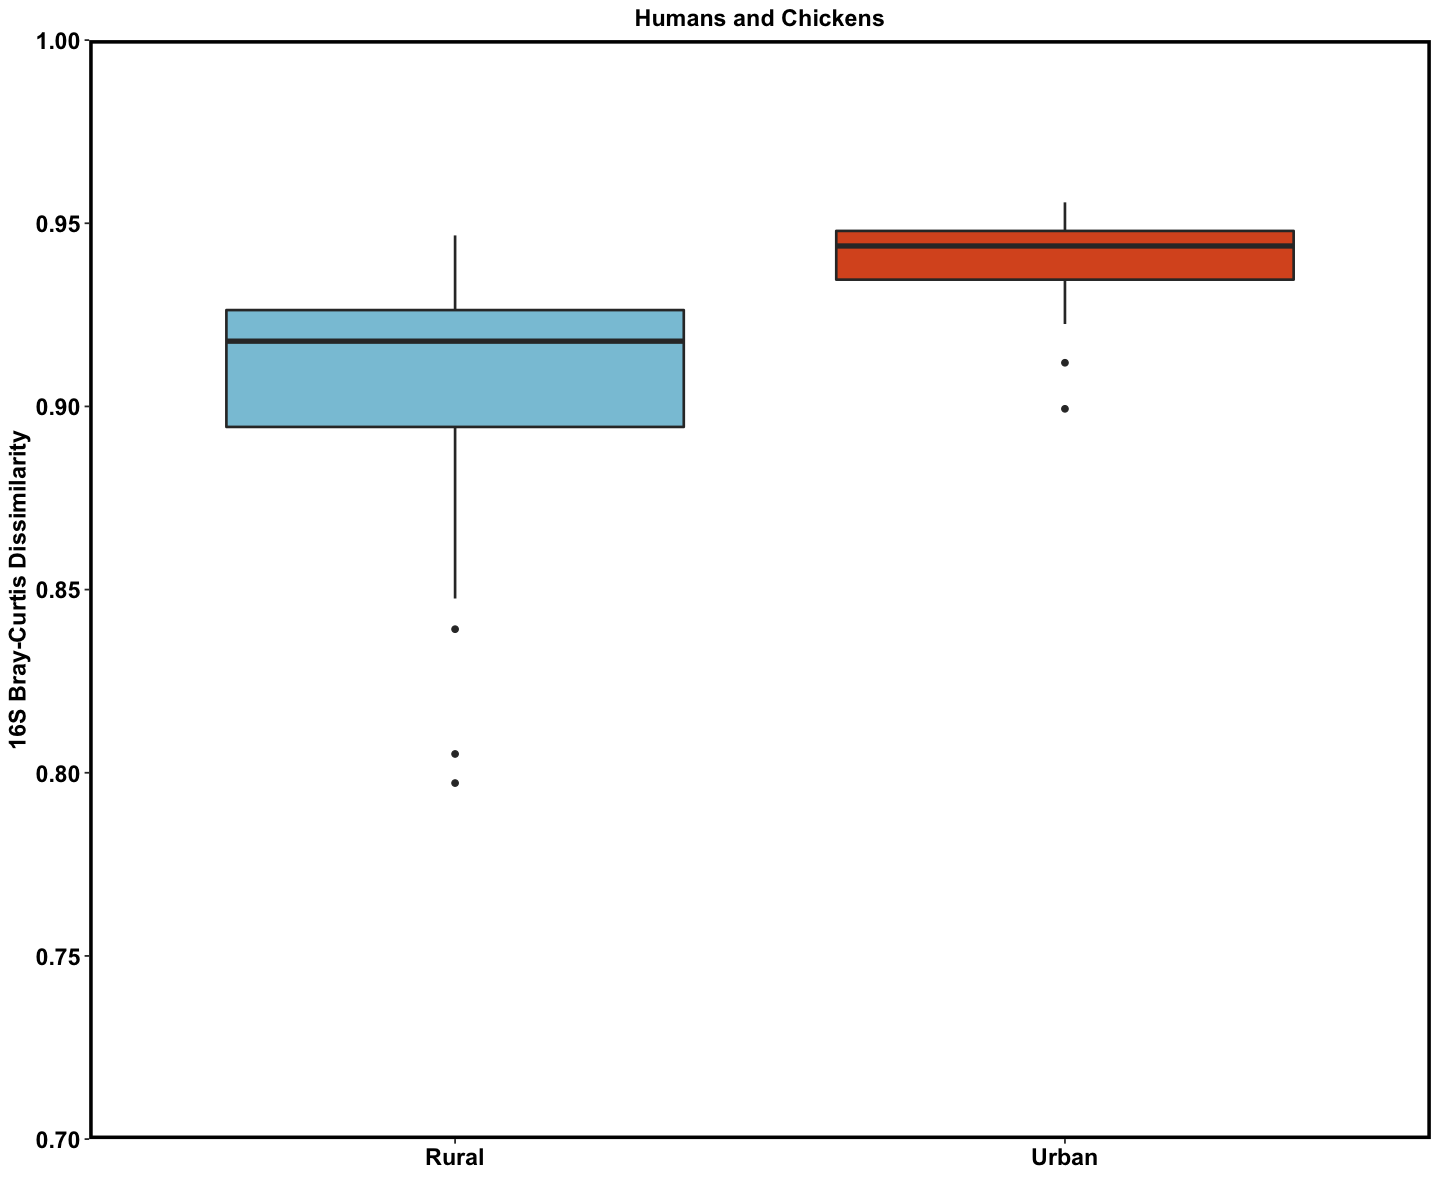

In [15]:
#plot human and chicken BC dissimilarity
plot_ch <- ggplot(ch_all, aes(area, braycurtis)) + 
  geom_boxplot(size=0.75,fill=c("#89C5DA", "#DA5724")) +
  ggtitle("Humans and Chickens") +
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA, size=2),
        axis.text.x = element_text(color="black", size=14, face="bold"), axis.text.y = element_text(color="black", size=14, face="bold"),
        axis.title.y=element_text(size=14, face="bold"),plot.title=element_text(size=14, face="bold", hjust=0.5))+
        scale_y_continuous(breaks = seq(0.7, 1.0, by=0.05), limits=c(0.7,1.0), expand=c(0,0))+
        labs( x ="", y = "16S Bray-Curtis Dissimilarity")+
        scale_fill_manual(values=c("#89C5DA", "#DA5724"))
plot_ch

#ggsave(plot=plot_ch, filename="chicken_human_bc_2.pdf",device="pdf", width=3.1, height=4, useDingbats = FALSE)


In [16]:
#wilcox rank sum for difference in means between two groups-chicken human
wilcox.test(braycurtis~area, ch_all, paired=FALSE, correct=FALSE, conf.int=TRUE, conf.level=0.95)
group_by(ch_all, area) %>%
  summarise(
    count = n(),
    median = median(braycurtis, na.rm = TRUE),
    IQR = IQR(braycurtis, na.rm = TRUE)
  )


	Wilcoxon rank sum exact test

data:  braycurtis by area
W = 70, p-value = 1.34e-05
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -0.03931171 -0.01456780
sample estimates:
difference in location 
           -0.02514889 


area,count,median,IQR
<chr>,<int>,<dbl>,<dbl>
Rural,20,0.9178133,0.03189904
Urban,25,0.9438005,0.01330371


In [17]:
#rural vs urban goat and human
#calculate distance bray curtis matrix 
#urban
distbray<-distance(ps_gh_u, method="bray")
distbray<-as.data.frame(as.matrix(distbray))
bray_gh_u<-distbray[(6:10), (1:5)]
bray_gh_u_list<-as.data.frame(as.matrix(unlist(bray_gh_u)))
rownames(bray_gh_u_list)<-c()
names(bray_gh_u_list)<-(c("braycurtis"))
bray_gh_u_list$area<-(c("Urban"))

#rural
distbray<-distance(ps_gh_r, method="bray")
distbray<-as.data.frame(as.matrix(distbray))
bray_gh_r<-distbray[(5:9), (1:4)]
bray_gh_r_list<-as.data.frame(as.matrix(unlist(bray_gh_r)))
rownames(bray_gh_r_list)<-c()
names(bray_gh_r_list)<-(c("braycurtis"))
bray_gh_r_list$area<-(c("Rural"))

gh_all<-rbind(bray_gh_r_list, bray_gh_u_list)
nrow(gh_all)
nrow(bray_gh_r_list)
nrow(bray_gh_u_list)

[1] 45

[1] 20

[1] 25

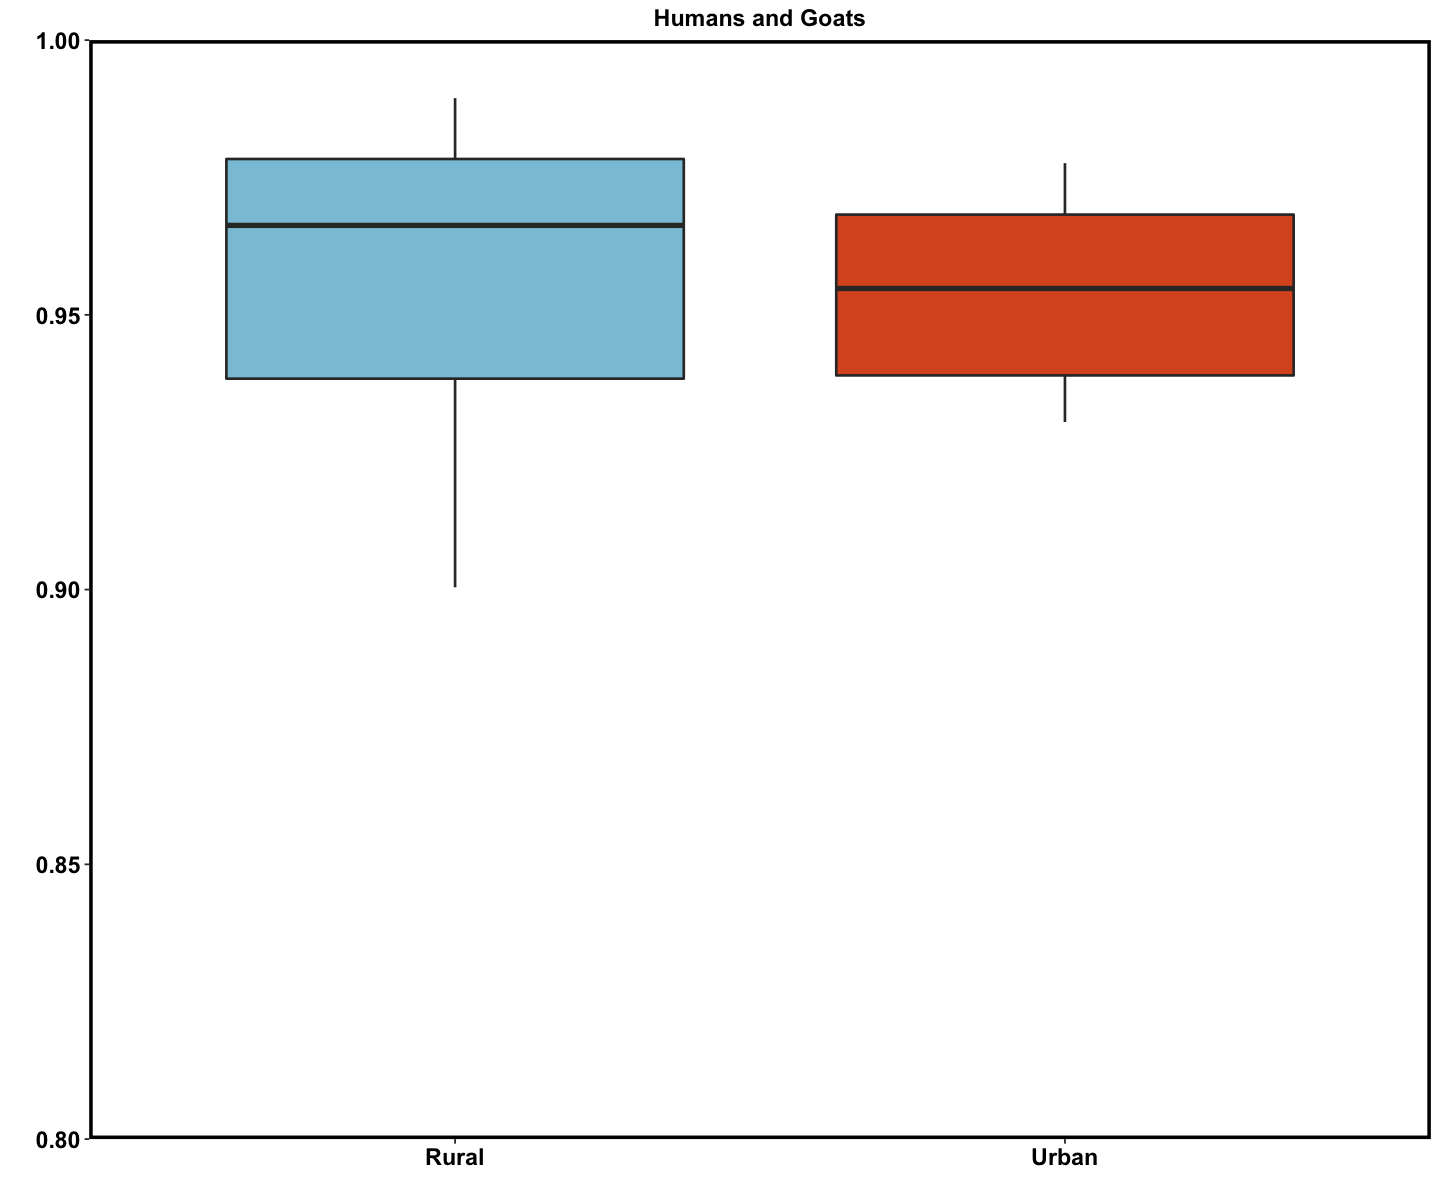

In [18]:
plot_gh <- ggplot(gh_all, aes(area, braycurtis)) + 
  geom_boxplot(size=0.75, fill=c("#89C5DA", "#DA5724")) +
  ggtitle("Humans and Goats") +
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA, size=2),
        axis.text.x = element_text(color="black", size=14, face="bold"), axis.text.y = element_text(color="black", size=14, face="bold"),
        axis.title.y=element_text(size=14, face="bold"),plot.title=element_text(size=14, face="bold", hjust=0.5))+
       scale_y_continuous(breaks = seq(0.8, 1.0, by=0.05), limits=c(0.8,1.0), expand=c(0,0))+
        labs( x ="", y = " ") 
        
plot_gh
#ggsave(plot=plot_gh, filename="goat_human_bc_2.pdf",device="pdf", width=3.1, height=4,useDingbats = FALSE)

In [19]:
wilcox.test(braycurtis~area, gh_all, paired=FALSE, correct=FALSE, conf.int=TRUE, conf.level=0.95)
group_by(gh_all, area) %>%
  summarise(
    count = n(),
    median = median(braycurtis, na.rm = TRUE),
    IQR = IQR(braycurtis, na.rm = TRUE)
  )


	Wilcoxon rank sum exact test

data:  braycurtis by area
W = 296, p-value = 0.3019
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -0.008526777  0.021869446
sample estimates:
difference in location 
           0.008319113 


area,count,median,IQR
<chr>,<int>,<dbl>,<dbl>
Rural,20,0.9662792,0.03997559
Urban,25,0.9547983,0.02926895


<a id='section4'></a>

# 4. PERMANOVA

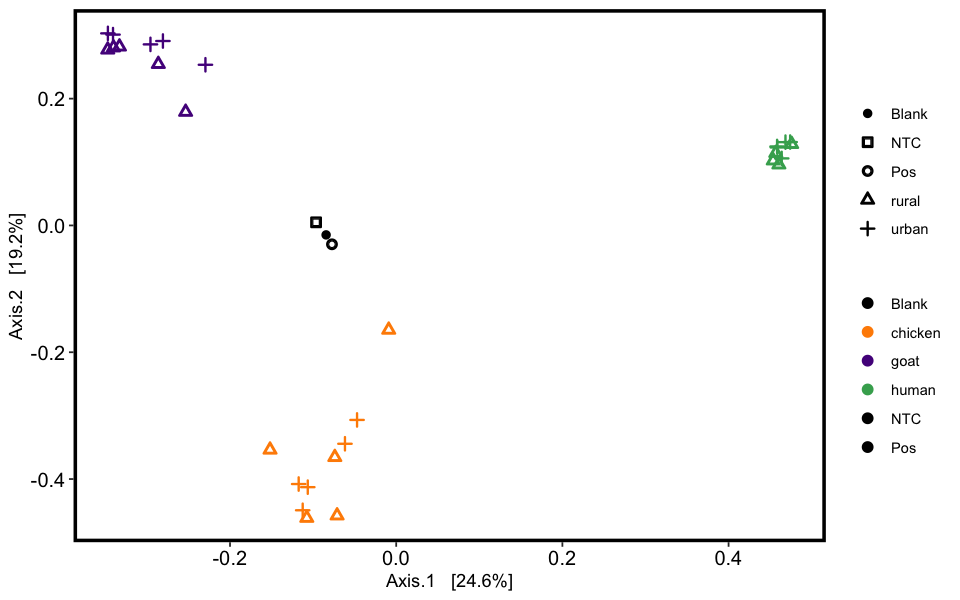

In [20]:
set.seed(1)
#PCoA of bray curtis dissimilarity-color coded by sample type-shape by urban vs rural 
all.pcoa.bray <- ordinate(ps_samples_sum, method="PCoA", distance="bray")
options(repr.plot.width = 8, repr.plot.height = 5) #for plotting size in jupyter
pcoa_plot<-plot_ordination(ps_samples_sum, all.pcoa.bray, color="anm", shape="loc") + 
geom_point(size=2,stroke=1)+
scale_shape_manual(values=c(16,0,1,2,3))+
scale_color_manual(values = c("black","#FF8C00", "#551A8B","#41ab5d","black","black"))+
theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA, size=2), legend.title = element_blank(),legend.key = element_rect(fill = NA),axis.text.y= element_text(size=12, color="black"),
        axis.text.x = element_text(size=12, color="black"))
pcoa_plot

#ggsave(plot=pcoa_plot, filename="PCoA.pdf",device="pdf", width=6, height=4, useDingbats=FALSE)


In [21]:
all = as(sample_data(ps_all), "data.frame")
all_bray = phyloseq::distance(ps_all, "bray")
all_adonis = adonis(all_bray ~ loc+anm, all)

all_adonis


Call:
adonis(formula = all_bray ~ loc + anm, data = all) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
loc        1    0.3565 0.35650  1.8356 0.03425  0.067 .  
anm        2    5.1969 2.59846 13.3792 0.49928  0.001 ***
Residuals 25    4.8554 0.19422         0.46647           
Total     28   10.4088                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [22]:
#permanova/adonis to test significance between urban and rural in chicken microbial communities using bray curtis 
chicken = as(sample_data(ps_ch), "data.frame")
chicken_bray = phyloseq::distance(ps_ch, "bray")
chicken_adonis = adonis(chicken_bray ~ loc, chicken)

chicken_adonis


Call:
adonis(formula = chicken_bray ~ loc, data = chicken) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)
loc        1   0.31863 0.31863  1.2895 0.13882  0.186
Residuals  8   1.97672 0.24709         0.86118       
Total      9   2.29535                 1.00000       

In [23]:
#permanova/adonis to test significance between urban and rural in goat microbial communities using bray-curtis 
goat = as(sample_data(ps_g), "data.frame")
goat_bray = phyloseq::distance(ps_g, "bray")
goat_adonis = adonis(goat_bray ~ Urban, goat)

goat_adonis


Call:
adonis(formula = goat_bray ~ Urban, data = goat) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)  
Urban      1   0.53935 0.53935  2.5446 0.24132  0.011 *
Residuals  8   1.69565 0.21196         0.75868         
Total      9   2.23500                 1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [24]:
#permanova/adonis to test significance between urban and rural in human microbial communities using bray-curtis
human = as(sample_data(ps_h), "data.frame")
human_bray = phyloseq::distance(ps_h, "bray")
human_adonis = adonis(human_bray ~ Urban, human)

human_adonis


Call:
adonis(formula = human_bray ~ Urban, data = human) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)  
Urban      1   0.13310 0.133099  1.7277 0.19796  0.019 *
Residuals  7   0.53926 0.077037         0.80204         
Total      8   0.67236                  1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

<a id='section5'></a>

# Without NTC Taxa

In [25]:
ps_ntc <- subset_samples(ps_prop, subset = anm %in% c("NTC"))
ps_blank<-subset_samples(ps_prop, subset=anm %in% c("Blank"))

In [26]:
ps_ntc = prune_taxa(taxa_sums(ps_ntc) > 0, ps_ntc)
ps_ntc
ntc_taxa<-colnames(otu_table(ps_ntc))

ps_blank=prune_taxa(taxa_sums(ps_blank) > 0, ps_blank)
ps_blank


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 140 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 140 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 7 taxa by 7 taxonomic ranks ]

In [27]:
#function to remove ntc from samples 
rm_taxa = function(physeq, contam){
  allTaxa = taxa_names(physeq)
  allTaxa <- allTaxa[!(allTaxa %in% contam)]
  return(prune_taxa(allTaxa, physeq))
}

ps_nocontam <- rm_taxa(ps_samples_sum, ntc_taxa)
ps_samples_sum
ps_nocontam

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5057 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 5057 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4917 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 4917 taxa by 7 taxonomic ranks ]

In [28]:
#subset data for pairwise comparisons 
ps_ch_uc<- subset_samples(ps_nocontam, subset = anm %in% c("chicken", "human")& loc %in% c("urban"))
ps_ch_rc<- subset_samples(ps_nocontam, subset = anm %in% c("chicken", "human")& loc %in% c("rural"))
ps_gh_uc<- subset_samples(ps_nocontam, subset = anm %in% c("goat", "human")& loc %in% c("urban"))
ps_gh_rc<- subset_samples(ps_nocontam, subset = anm %in% c("goat", "human")& loc %in% c("rural"))

#sample_data(ps_ch_uc)
#sample_data(ps_gh_rc)

In [29]:
#rural vs urban chicken and human
#calculate distance bray curtis matrix 
#urban
distbray<-distance(ps_ch_uc, method="bray")
distbray<-as.data.frame(as.matrix(distbray))
bray_ch_uc<-distbray[(6:10), (1:5)]
bray_ch_uc_list<-as.data.frame(as.matrix(unlist(bray_ch_uc)))
rownames(bray_ch_uc_list)<-c()
names(bray_ch_uc_list)<-(c("braycurtis"))
bray_ch_uc_list$area<-(c("Urban"))

#rural
distbray<-distance(ps_ch_rc, method="bray")
distbray<-as.data.frame(as.matrix(distbray))
bray_ch_rc<-distbray[(6:9), (1:5)]
bray_ch_rc_list<-as.data.frame(as.matrix(unlist(bray_ch_rc)))
rownames(bray_ch_rc_list)<-c()
names(bray_ch_rc_list)<-(c("braycurtis"))
bray_ch_rc_list$area<-(c("Rural"))

ch_all<-rbind(bray_ch_rc_list, bray_ch_uc_list)
nrow(bray_ch_rc_list)
nrow(bray_ch_uc_list)
nrow(ch_all)


[1] 20

[1] 25

[1] 45

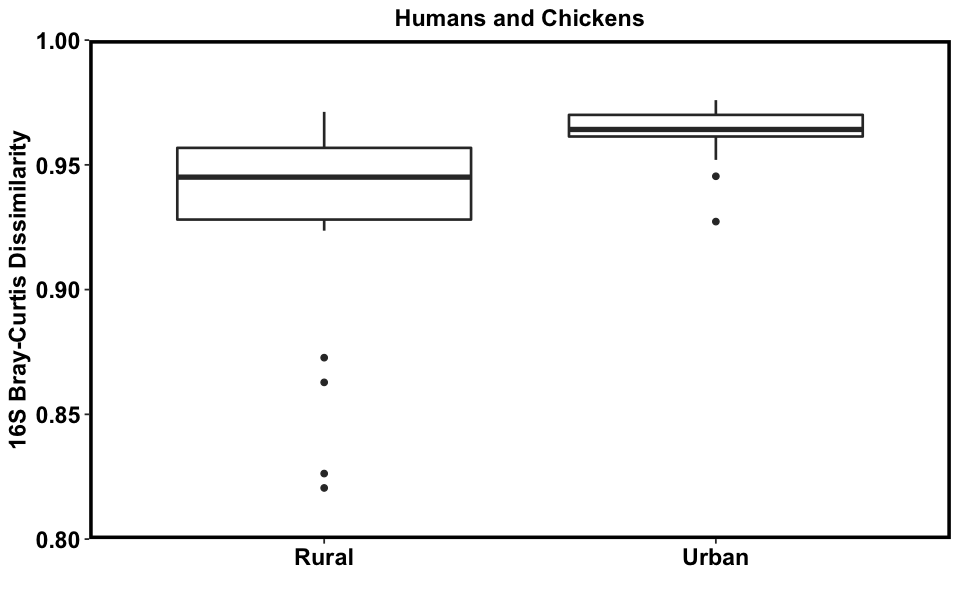

In [30]:
plot_ch_nocontam <- ggplot(ch_all, aes(area, braycurtis)) + 
  geom_boxplot(size=0.75) +
  ggtitle("Humans and Chickens") +
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA, size=2),
        axis.text.x = element_text(color="black", size=14, face="bold"), axis.text.y = element_text(color="black", size=14, face="bold"),
        axis.title.y=element_text(size=14, face="bold"),plot.title=element_text(size=14, face="bold", hjust=0.5))+
        scale_y_continuous(breaks = seq(0.8, 1.0, by=0.05), limits=c(0.8,1.0), expand=c(0,0))+
        labs( x ="", y = "16S Bray-Curtis Dissimilarity")
plot_ch_nocontam

#ggsave(plot=plot_ch_nocontam, filename="chicken_human_remove_taxa.pdf",device="pdf", width=3.1, height=4, useDingbats = FALSE)

In [31]:
#test for difference in means between two groups 
wilcox.test(braycurtis~area, ch_all, paired=FALSE, correct=FALSE, conf.int=TRUE, conf.level=0.95)
group_by(ch_all, area) %>%
  summarise(
    count = n(),
    median = median(braycurtis, na.rm = TRUE),
    IQR = IQR(braycurtis, na.rm = TRUE)
  )


	Wilcoxon rank sum exact test

data:  braycurtis by area
W = 81, p-value = 5.247e-05
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -0.02790885 -0.01081685
sample estimates:
difference in location 
           -0.01914563 


area,count,median,IQR
<chr>,<int>,<dbl>,<dbl>
Rural,20,0.9450732,0.028735750
Urban,25,0.9641837,0.008669254


In [32]:
#rural vs urban goat and human
#calculate distance bray curtis matrix 
#urban
distbray<-distance(ps_gh_uc, method="bray")
distbray<-as.data.frame(as.matrix(distbray))
bray_gh_uc<-distbray[(6:10), (1:5)]
bray_gh_uc_list<-as.data.frame(as.matrix(unlist(bray_gh_uc)))
rownames(bray_gh_uc_list)<-c()
names(bray_gh_uc_list)<-(c("braycurtis"))
bray_gh_uc_list$area<-(c("Urban"))

#rural
distbray<-distance(ps_gh_rc, method="bray")
distbray<-as.data.frame(as.matrix(distbray))
bray_gh_rc<-distbray[(5:9), (1:4)]
bray_gh_rc_list<-as.data.frame(as.matrix(unlist(bray_gh_rc)))
rownames(bray_gh_rc_list)<-c()
names(bray_gh_rc_list)<-(c("braycurtis"))
bray_gh_rc_list$area<-(c("Rural"))

gh_all<-rbind(bray_gh_rc_list, bray_gh_uc_list)
nrow(gh_all)
nrow(bray_gh_rc_list)
nrow(bray_gh_uc_list)

[1] 45

[1] 20

[1] 25

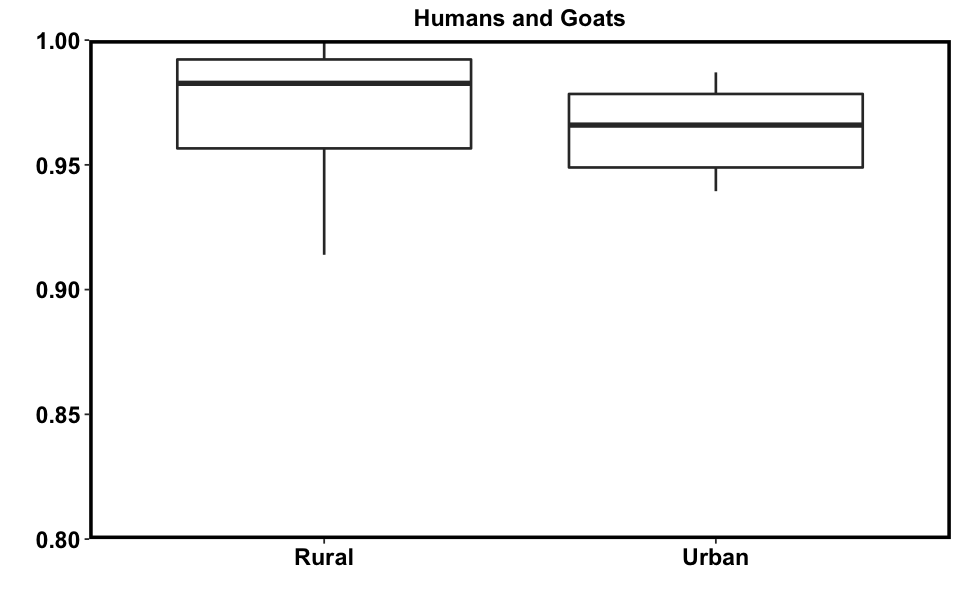

In [33]:
plot_gh_nocontam <- ggplot(gh_all, aes(area, braycurtis)) + 
  geom_boxplot(size=0.75) +
  ggtitle("Humans and Goats") +
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA, size=2),
        axis.text.x = element_text(color="black", size=14, face="bold"), axis.text.y = element_text(color="black", size=14, face="bold"),
        axis.title.y=element_text(size=14, face="bold"),plot.title=element_text(size=14, face="bold", hjust=0.5))+
        scale_y_continuous(breaks = seq(0.8, 1.0, by=0.05), limits=c(0.8,1.0), expand=c(0,0))+
        labs( x ="", y = " ")
plot_gh_nocontam
#ggsave(plot=plot_gh_nocontam, filename="goat_human_bc_remove_taxa.pdf",device="pdf", width=3.1, height=4,useDingbats = FALSE)

In [34]:
wilcox.test(braycurtis~area, gh_all, paired=FALSE, correct=FALSE, conf.int=TRUE, conf.level=0.95)
group_by(gh_all, area) %>%
  summarise(
    count = n(),
    median = median(braycurtis, na.rm = TRUE),
    IQR = IQR(braycurtis, na.rm = TRUE)
  )


	Wilcoxon rank sum exact test

data:  braycurtis by area
W = 330, p-value = 0.06909
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -0.001222201  0.024471419
sample estimates:
difference in location 
            0.01218979 


area,count,median,IQR
<chr>,<int>,<dbl>,<dbl>
Rural,20,0.9826756,0.03564730
Urban,25,0.9659354,0.02946143
